# Seminar Project: Subsetting Speeches
---------------
``` 

Jakob Amann
Elias Gabriel Heppner, 1244414
Andri Rutschmann

### Loading Packages


In [1]:
import numpy as np 
import pandas as pd 
import time
import pickle
import time
import os
import datetime
import zipfile
# from tqdm.auto import tqdm
from tqdm import tqdm # use this import for better kaggle compatibility
from collections import defaultdict 
import re
import matplotlib.pyplot as plt
import math


import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Andri\envs\css\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Andri\envs\css\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\Andri\envs\css\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Load Speeches Data


In [ ]:
# For kaggle, just reload .csv (not entering .csv)
file_path = '/kaggle/input/sub-speeches-data-input/sub_speeches.pkl'
df = pd.read_pickle(file_path)
print(df.isna().any())
df.head()

In [ ]:
# For Local Use
os.chdir("../data/opendiscourse")

# zip_file_path = "sub_speeches.zip"
zip_file_path = r"sub_speeches.pkl.zip" # changed it to pickle file as .csv introduced NA values

# Name of the CSV file inside the zip file
# csv_filename = "sub_speeches.csv"
pkl_filename = r"sub_speeches.pkl"

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Check if the CSV file exists in the zip file
    if pkl_filename in zip_ref.namelist():
        # Extract the CSV file
        with zip_ref.open(pkl_filename) as csv_file:
            # Read the CSV file using pandas
            # df = pd.read_csv(csv_file)
            df = pd.read_pickle(csv_file)

            print(df.head())  # Display the first few rows of the dataframe
    else:
        print(f"{pkl_filename} not found in the zip file.")

df.isna().any()

# Preprocessing

In order to be able to use the sentence manifestoberta, we need to create a list of sentences with maximum 200 tokens per sentence/unit of analysis. 

In [ ]:
stopword removal, subsampling

## From Speeches Preproc

Use Speech recognition RegEx, use Topic Model Bert, use already existing RegEx. 


In [2]:
df = pd.read_pickle('../data/opendiscourse/sub_speeches.pkl')

In [14]:
# Preprocess, filter speeches starting with "Sehr geehrte" Damen und Herren, Bundespräsident
df_with_speeches = df.copy()
# pattern_speech_formulation = r"^Sehr geehrte(?:r)?(?: Damen und Herren| Herr Bundespräsident| Kolleginnen und Kollegen|)"
# pattern_speech_formulation = r"^Sehr geehrte(?:r)? (Damen und Herren|Herr Bundespräsident|Frau Bundespräsidentin|Kolleginnen und Kollegen|Abgeordnete[n]?|Minister[in]?|Präsident[in]?|Vizepräsident[in]?|Bürgermeister[in]?)(,)?"
pattern_speech_formulation = r"^Sehr geehrte(?:r)?(?: Damen und Herren| Frau| Herr)?(?: Bundespräsidentin| Bundespräsident| Kolleginnen und Kollegen| Abgeordnete| Ministerin| Minister| Präsidentin| Präsident| Vizepräsidentin| Vizepräsident| Bürgermeisterin| Bürgermeister|)?(?:\s\w+)*(,)?"

matches_speeches = df_with_speeches['speech_content'].str.contains(pattern_speech_formulation, case=False, flags=re.IGNORECASE)
df_with_speeches = df_with_speeches[matches_speeches]
print(len(df))
print(len(df_with_speeches))

107646
2532


C:\Users\Jakob\AppData\Local\Temp\ipykernel_24660\815314128.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_speeches = df_with_speeches['speech_content'].str.contains(pattern_speech_formulation, case=False, flags=re.IGNORECASE)


In [4]:
# we need to look at speech_content
# Let's start with Ukraine War
fin_df = df.copy()

# Sample regex pattern to match speeches about the war on Ukraine
pattern_ukraine_war = r'(?i)\b(Krieg|Konflikt|Invasion|Krise|Angriffskrieg|conflict|crisis)\b.*\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b|\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b.'
# pattern_ukraine_war = r'ukrain|russi|russl'
matches_ukraine_war = fin_df['speech_content'].str.contains(pattern_ukraine_war, case=False, flags=re.IGNORECASE)
ukraine_war_speeches = fin_df[matches_ukraine_war]
print(len(ukraine_war_speeches))


# Now Covid
pattern_covid = r'(?i)\b(COVID-19|Coronavirus|Pandemie|SARS-CoV-2|Quarantäne|Lockdown|Social Distancing|Ausgangsbeschränkung(en)?|Maskenpflicht|Impfpass|Corona-Virus|Infektion(en)?|Gesundheitsnotstand|Impfpflicht)\b'
# pattern_covid = r'cov|corona'
matches_covid = fin_df['speech_content'].str.contains(pattern_covid, case=False, flags=re.IGNORECASE)
covid_speeches = fin_df[matches_covid]
print(len(covid_speeches))

# Migration & Refugees
pattern_migration = r'(?i)\b(Flüchtlinge?|Migration|Asylbewerber?|Geflüchtete?|Asylverfahren|Einwanderer?|Auswanderer?|Immigrant(en)?|Emigrant(en)?|Zuwanderer?|Vertriebene?|Schutzsuchende?|Migranten?|Asylrecht|Grenzübergang|Visapolitik|Einreiseverbot)\b'
# pattern_migration = r'migra|flucht|flücht|asylbewerbe'
matches_migration = fin_df['speech_content'].str.contains(pattern_migration, case=False, flags=re.IGNORECASE)
migration_speeches = fin_df[matches_migration]
print(len(migration_speeches))

C:\Users\Andri\AppData\Local\Temp\ipykernel_16736\3499145003.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_ukraine_war = fin_df['speech_content'].str.contains(pattern_ukraine_war, case=False, flags=re.IGNORECASE)


3684


C:\Users\Andri\AppData\Local\Temp\ipykernel_16736\3499145003.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_covid = fin_df['speech_content'].str.contains(pattern_covid, case=False, flags=re.IGNORECASE)


3395


C:\Users\Andri\AppData\Local\Temp\ipykernel_16736\3499145003.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_migration = fin_df['speech_content'].str.contains(pattern_migration, case=False, flags=re.IGNORECASE)


4968


## Topic Modelling

In [103]:
def get_topic_from_speech(speech):
    '''
    input: speech as string
    workings: tokenize speech into word tokens, take 
    output: most common aggregated topic over all chunks as string
    '''
    model = "chkla/parlbert-topic-german"
    if torch.cuda.is_available():
        model = model.cuda()
    pipeline_classification_topics = pipeline("text-classification", model="chkla/parlbert-topic-german", return_all_scores=False) # same return_all_scores=True, but without warning

    max_length = 400 # actual limit is 512, but as we have a different tokenizer the smaller size should be make up for differences
    tokens = word_tokenize(speech, language='german')
    token_chunks = []
    number_of_splits = math.ceil(len(tokens)/max_length)
    cut_on_length = 0
    for i in range(number_of_splits):
        i = i+1 # we want to start with 512 and not 0
        cut_off_length = i*max_length
        if cut_off_length > len(tokens):
            cut_off_length = len(tokens)-1 # as length count includes index position 0
        token_chunk = tokens[cut_on_length:cut_off_length]
        cut_on_length = cut_off_length # in the next iteration of the loop this, will be the starting point for the separation of the list
        token_chunks.append(token_chunk)

    topics = []
    for chunk in token_chunks:
        chunk = ' '.join(chunk)
        topic = pipeline_classification_topics(chunk)
        # print(topic)
        topics.append(topic[0]) # the results come as a list

    most_common_topic = max([topic['label'] for topic in topics])

    return most_common_topic
 

test_speech = df['speech_content'][33494]
get_topic_from_speech(test_speech)

c:\Users\Jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


'Macroeconomics'

# Groundtruthing

## Manifestoberta

Let's go with the sentence model as the context model adds just a mere 7% accuracy and is way more complex to implement. I think, we'd have to use each sentence + it's previous/following sentence as context.

The sentence model should be used for sentences, but let's check if there are any restrictions and/or problems arising, when we give multiple sentences.

In [ ]:
# https://huggingface.co/manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

if torch.cuda.is_available():
    model = model.cuda()
sentence = "We will restore funding to the Global Environment Facility and the Intergovernmental Panel on Climate Change, to support critical climate science research around the world"

inputs = tokenizer(sentence,
                   return_tensors="pt",
                   max_length=200,  #we limited the input to 200 tokens during finetuning
                   padding="max_length",
                   truncation=True
                   )
# If CUDA is available, also move the inputs to GPU
if torch.cuda.is_available():
    inputs = {key: value.cuda() for key, value in inputs.items()}
    
logits = model(**inputs).logits

# Move logits back to CPU for further operations if needed
if torch.cuda.is_available():
    logits = logits.cpu()


probabilities = torch.softmax(logits, dim=1).tolist()[0]
probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}
probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
print(probabilities)
# {'501 - Environmental Protection: Positive': 67.28, '411 - Technology and Infrastructure': 15.19, '107 - Internationalism: Positive': 13.63, '416 - Anti-Growth Economy: Positive': 2.02...

predicted_class = model.config.id2label[logits.argmax().item()]
print(predicted_class)
# 501 - Environmental Protection: Positive


manifesto_dimensions = list(probabilities.keys()) 
print(manifesto_dimensions)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


{'501 - Environmental Protection: Positive': 67.28, '411 - Technology and Infrastructure': 15.19, '107 - Internationalism: Positive': 13.63, '416 - Anti-Growth Economy: Positive': 2.02, '506 - Education Expansion': 0.26, '703 - Agriculture and Farmers: Positive': 0.26, '108 - European Community/Union: Positive': 0.21, '101 - Foreign Special Relationships: Positive': 0.16, '410 - Economic Growth: Positive': 0.13, '104 - Military: Positive': 0.06, '402 - Incentives': 0.05, '502 - Culture: Positive': 0.05, '601 - National Way of Life: Positive': 0.05, '201 - Freedom and Human Rights': 0.04, '403 - Market Regulation': 0.04, '407 - Protectionism: Negative': 0.04, '504 - Welfare State Expansion': 0.04, '109 - Internationalism: Negative': 0.03, '301 - Federalism': 0.03, '303 - Governmental and Administrative Efficiency': 0.03, '406 - Protectionism: Positive': 0.03, '408 - Economic Goals': 0.03, '605 - Law and Order: Positive': 0.03, '105 - Military: Negative': 0.02, '106 - Peace': 0.02, '305 

In [ ]:
def get_average_dimension_values(speech_in_sentences):
    '''
    input: 
    speech_in_sentences: a whole speech/article as list of strings/sentences. Each single object should have at max 200 tokens to be usable for the model 

    output:
    dimension_values_dict: dict with all dimensions, sorted by the highest values with manifesto_dimensions as keys
    '''

    # Initialize a dictionary to hold the sum of probabilities for each class
    sum_probabilities = defaultdict(float)  # this makes sure we have just 0.0 if the key was not found

    for sentence in speech_in_sentences:
        # Tokenize and move inputs to the same device as model
        inputs = tokenizer(sentence,
                           return_tensors="pt",
                           max_length=200,  # we limited the input to 200 tokens during finetuning
                           padding="max_length",
                           truncation=True
                           ).to(device)

        # Perform inference
        with torch.no_grad():  # Inference mode, no gradients needed
            logits = model(**inputs).logits

        # Move logits back to CPU for further operations
        probabilities = torch.softmax(logits, dim=1).cpu().tolist()[0]
        probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}

        # Add the probabilities to the running total
        for dimension, probability in probabilities.items():
            sum_probabilities[dimension] += probability

    # Calculate the average probabilities for each dimension
    avg_probabilities = {dimension: round(total / len(speech_in_sentences), 2) for dimension, total in sum_probabilities.items()}
    # Sort the average probabilities by the highest values
    avg_probabilities_sorted = dict(sorted(avg_probabilities.items(), key=lambda item: item[1], reverse=True))
    return avg_probabilities_sorted

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

Let's make some example visualisations using the axis, military: Positive/Negative and European Community/Union: Positive/Negative. 

For that, I will use the first 5 speeches. Already takes about 6 mins. 

In [20]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

n = 1000 # how many rows to be taken into consideration

result_dict_list = [] 
for speech in tqdm(ukraine_war_speeches['speech_content'][:n], miniters = 1): # first two speeches already take around 2.45 min
    speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
    result_dict = get_average_dimension_values(speech_in_sentences)
    result_dict_list.append(result_dict)
    
# add results to fin_df
results_df = pd.DataFrame(result_dict_list)
ukraine_war_speeches = pd.concat([ukraine_war_speeches.reset_index(drop=True), results_df], axis=1)


result_dict_list = [] 
for speech in tqdm(migration_speeches['speech_content'][:n], miniters = 1): # first two speeches already take around 2.45 min
    speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
    result_dict = get_average_dimension_values(speech_in_sentences)
    result_dict_list.append(result_dict)
    
results_df = pd.DataFrame(result_dict_list)
migration_speeches = pd.concat([migration_speeches.reset_index(drop=True), results_df], axis=1)

    

result_dict_list = [] 
for speech in tqdm(covid_speeches['speech_content'][:n], miniters = 1): # first two speeches already take around 2.45 min
    speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
    result_dict = get_average_dimension_values(speech_in_sentences)
    result_dict_list.append(result_dict)
    
results_df = pd.DataFrame(result_dict_list)
covid_speeches = pd.concat([covid_speeches.reset_index(drop=True), results_df], axis=1)

100%|██████████| 1000/1000 [19:50<00:00,  1.19s/it]


In [59]:
# # print(result_dict_list)

# # Extract the values for the keys
# x_values = [d['104 - Military: Positive'] - d['105 - Military: Negative'] for d in result_dict_list]
# y_values = [d['108 - European Community/Union: Positive'] - d['110 - European Community/Union: Negative'] for d in result_dict_list]

# # Create the scatter plot
# plt.figure(figsize=(10, 10))
# plt.scatter(x_values, y_values)

# # Set the labels for the axes
# plt.xlabel('Military (Positive - Negative)')
# plt.ylabel('European Community (Positive - Negative)')

# # Display the plot
# plt.show()

print(covid_speeches.columns)

Index(['id_x', 'session', 'electoral_term', 'date', 'document_url',
       'speech_content', 'politician_id', 'first_name', 'last_name',
       'faction_id', 'abbreviation', 'full_name',
       '703 - Agriculture and Farmers: Positive', '305 - Political Authority',
       '403 - Market Regulation', '503 - Equality: Positive',
       '504 - Welfare State Expansion',
       '501 - Environmental Protection: Positive',
       '303 - Governmental and Administrative Efficiency', '202 - Democracy',
       '402 - Incentives', '401 - Free Market Economy',
       '701 - Labour Groups: Positive', '411 - Technology and Infrastructure',
       '414 - Economic Orthodoxy', '601 - National Way of Life: Positive',
       '110 - European Community/Union: Negative', '506 - Education Expansion',
       '416 - Anti-Growth Economy: Positive',
       '606 - Civic Mindedness: Positive', '201 - Freedom and Human Rights',
       '505 - Welfare State Limitation',
       '108 - European Community/Union: Positive'

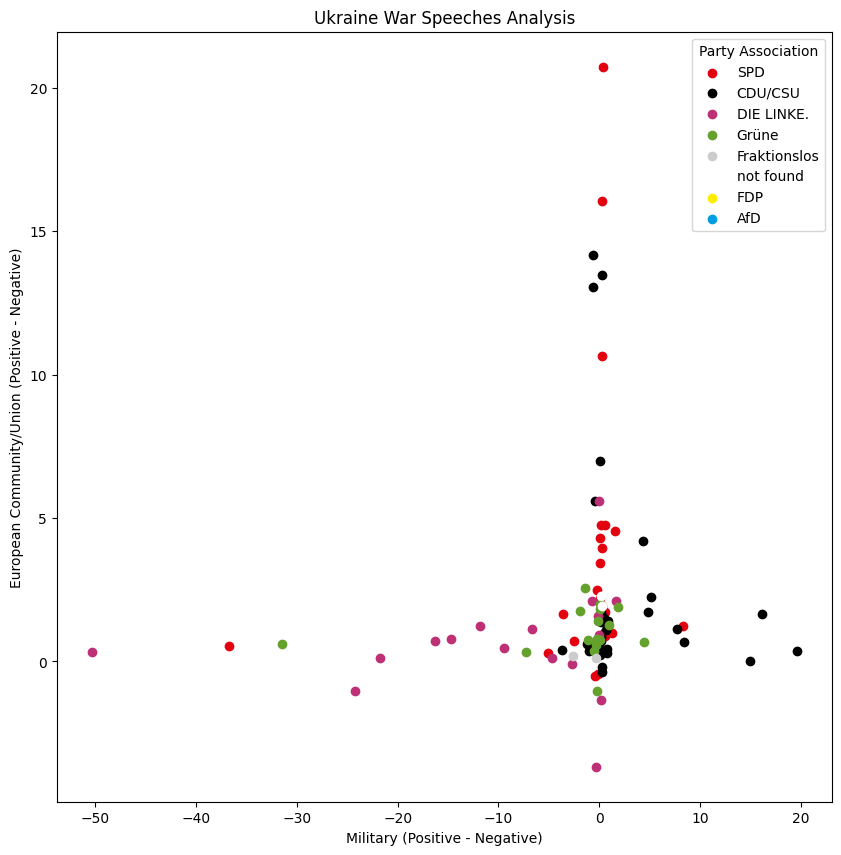

0       3.10
1       1.47
2       0.45
3       2.34
4       7.05
        ... 
3123     NaN
3124     NaN
3125     NaN
3126     NaN
3127     NaN
Name: 108 - European Community/Union: Positive, Length: 3128, dtype: float64

In [61]:
import matplotlib.pyplot as plt

# Assuming ukraine_war_speeches is a DataFrame and color_map is defined as above.

plt.figure(figsize=(10, 10))

# Compute the differences for x_values and y_values for all rows outside the loop to optimize performance
x_values = ukraine_war_speeches['104 - Military: Positive'] - ukraine_war_speeches['105 - Military: Negative']
y_values = ukraine_war_speeches['108 - European Community/Union: Positive'] - ukraine_war_speeches['110 - European Community/Union: Negative']

# Loop through the color map to plot each party separately
for party, color in color_map.items():
    # Filter indices for the current party
    indices = [i for i, abbr in enumerate(ukraine_war_speeches['abbreviation']) if abbr == party]
    # Plot using only the filtered indices for x and y values
    plt.scatter(x_values.iloc[indices], y_values.iloc[indices], color=color, label=party)

plt.xlabel('Military (Positive - Negative)')
plt.ylabel('European Community/Union (Positive - Negative)')
plt.title('Ukraine War Speeches Analysis')
plt.legend(title="Party Association")
plt.show()
ukraine_war_speeches['108 - European Community/Union: Positive']

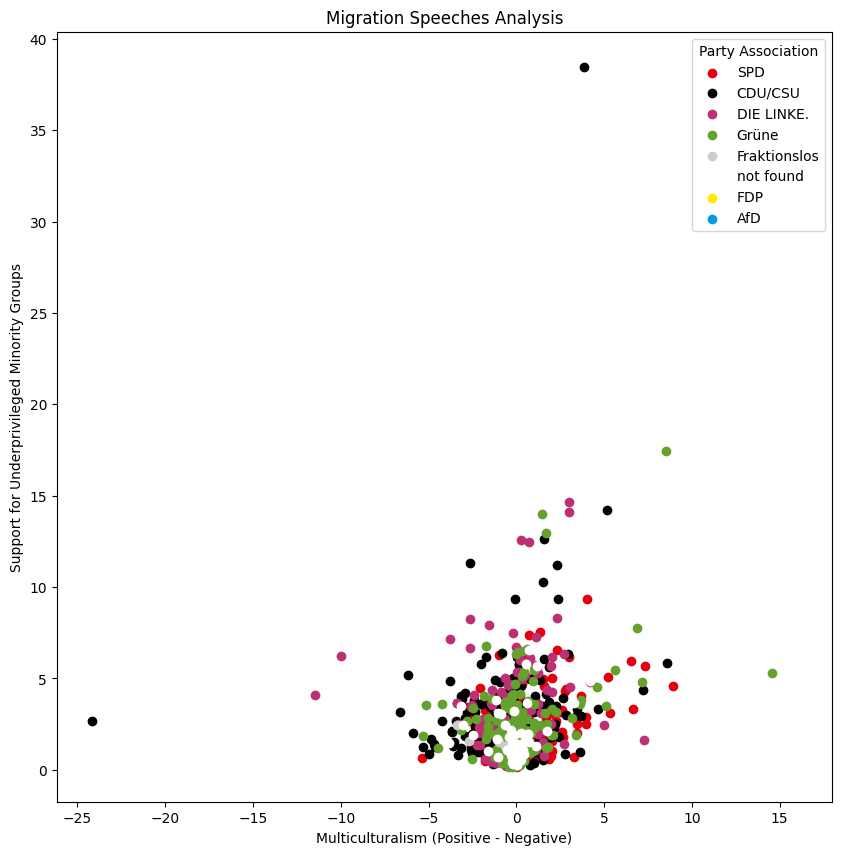

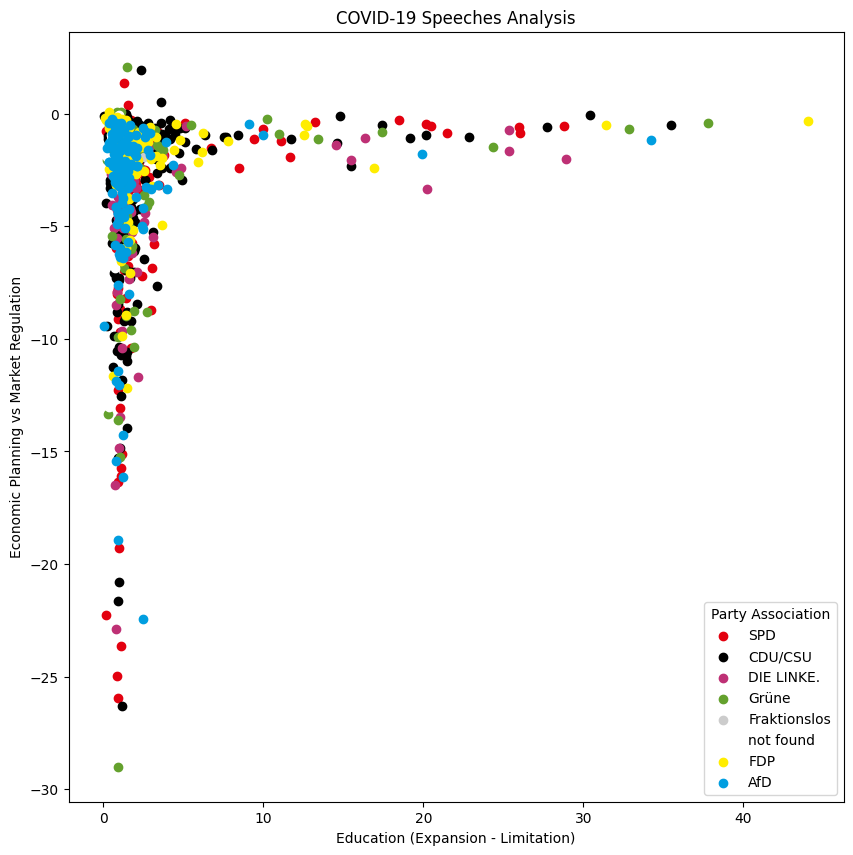

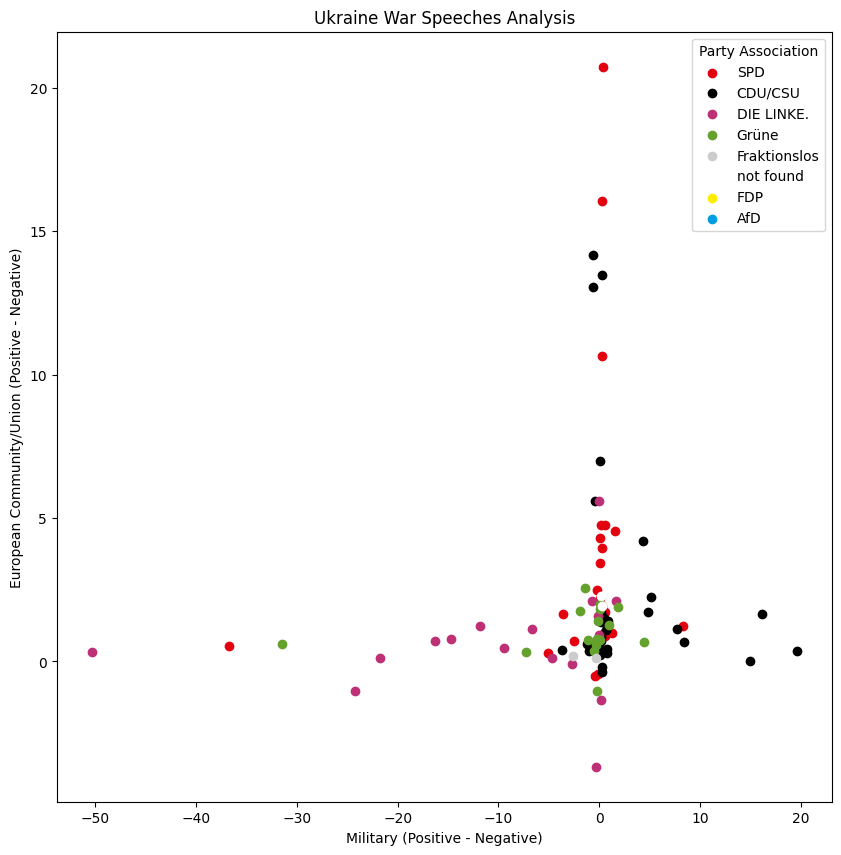

In [62]:
import matplotlib.pyplot as plt

# Define the color_map as given previously
# Assuming color_map is already defined

# Function to plot speeches analysis
def plot_speeches_analysis(df, x_columns, y_columns, x_label, y_label, title):
    plt.figure(figsize=(10, 10))
    for party, color in color_map.items():
        indices = [i for i, abbr in enumerate(df['abbreviation']) if abbr == party]
        x_values = df[x_columns[0]][indices] - df[x_columns[1]][indices] if len(x_columns) > 1 else df[x_columns[0]][indices]
        y_values = df[y_columns[0]][indices] - df[y_columns[1]][indices] if len(y_columns) > 1 else df[y_columns[0]][indices]
        plt.scatter(x_values, y_values, color=color, label=party)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title="Party Association")
    plt.show()

# Plot for migration_speeches
plot_speeches_analysis(migration_speeches, 
                       ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative'], 
                       ['705 - Underprivileged Minority Groups'], 
                       'Multiculturalism (Positive - Negative)', 
                       'Support for Underprivileged Minority Groups', 
                       'Migration Speeches Analysis')

# Plot for covid_speeches
plot_speeches_analysis(covid_speeches, 
                       ['506 - Education Expansion', '507 - Education Limitation'], 
                       ['404 - Economic Planning', '403 - Market Regulation'], 
                       'Education (Expansion - Limitation)', 
                       'Economic Planning vs Market Regulation', 
                       'COVID-19 Speeches Analysis')
plot_speeches_analysis(ukraine_war_speeches,
                       ['104 - Military: Positive', '105 - Military: Negative'],
                       ['108 - European Community/Union: Positive', '110 - European Community/Union: Negative'],
                       'Military (Positive - Negative)',
                       'European Community/Union (Positive - Negative)',
                       'Ukraine War Speeches Analysis')



In [57]:
# import os

# # Define the path where the new folder will be created
# folder_path = '/kaggle/working/outputs'

# # Check if the folder already exists
# if not os.path.exists(folder_path):
#     # If the folder does not exist, create it
#     os.makedirs(folder_path)
#     print(f"Folder '{folder_path}' created.")
# else:
#     print(f"Folder '{folder_path}' already exists.")

# ukraine_war_speeches.to_pickle('/kaggle/working/outputs/ukraine_war_speeches.pkl')
# migration_speeches.to_pickle('/kaggle/working/outputs/migration_speeches.pkl')
# covid_speeches.to_pickle('/kaggle/working/outputs/covid_speeches.pkl')


Folder '/kaggle/working/outputs' already exists.


## Implementing Topic Modelling Bert


In [1]:
from transformers import pipeline

pipeline_classification_topics = pipeline("text-classification", model="chkla/parlbert-topic-german", return_all_scores=False)
text = "Das Sachgebiet Investive Ausgaben des Bundes Bundesfinanzminister Apel hat gemäß BMF Finanznachrichten vom 1. Januar erklärt, die Investitionsquote des Bundes sei in den letzten zehn Jahren nahezu konstant geblieben."
pipeline_classification_topics(text) # Macroeconomics


c:\Users\Jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config.json: 100%|██████████| 1.61k/1.61k [00:00<?, ?B/s]
c:\Users\Jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jakob\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mod

[{'label': 'Macroeconomics', 'score': 0.9967405200004578}]

In [36]:

pipeline_classification_topics = pipeline("text-classification", model="chkla/parlbert-topic-german", top_k=None)
text = "Das Sachgebiet Investive Ausgaben des Bundes Bundesfinanzminister Apel hat gemäß BMF Finanznachrichten vom 1. Januar erklärt, die Investitionsquote des Bundes sei in den letzten zehn Jahren nahezu konstant geblieben."
topic_values = pipeline_classification_topics(text) # Macroeconomics


topic_values[0]
result_list = []
test_speech = ukraine_war_speeches['speech_content'].iloc[5]
test_speech_in_sentences = nltk.tokenize.sent_tokenize(test_speech)

for sentence in tqdm(test_speech_in_sentences):
    topic_values = pipeline_classification_topics(sentence)
    result_list.append(topic_values)



NameError: name 'ukraine_war_speeches' is not defined

In [37]:
result_list[0][0]
num_values = np.zeros(21)
topics = ['' for _ in range(21)]
for result in result_list:
    result_dicts = result[0]
    index_counter = 0
    for dict in result_dicts:
        old_value = num_values[index_counter]
        new_value = old_value + dict['score']
        num_values[index_counter] = new_value
        topics[index_counter] = dict['label']
        index_counter += 1

num_values
for idx,value in enumerate(num_values): 
    num_values[idx] = value/len(result_list)
combined = zip(topics, num_values)
combined_list = list(combined)
combined_list   

IndexError: list index out of range

In [38]:
from collections import defaultdict

# Initialize a defaultdict for total scores and counts
total_scores = defaultdict(float)
counts = defaultdict(int)

# # Iterate over the list and each dictionary
# for lst in result_list:
#     for d in lst:
#         print(d[0])
   

# Calculate the average scores
average_scores = {label: total / counts[label] for label, total in total_scores.items()}
average_scores

{}

## Random Stuff, to be deleted

In [ ]:
import nltk

# Ensure the punkt tokenizer is downloaded
nltk.download('punkt')

test_text = df.loc[1]['speech_content']

# Split the text into sentences
test_text_in_sentences = nltk.tokenize.sent_tokenize(test_text)

In [ ]:
test_text = "Sehr geehrte Damen und Herren,ich stehe heute vor Ihnen, um über die Covid-19 Restriktionen zu sprechen, die unser Land seit Monaten in einem eisernen Griff halten. Als Vertreter der Alternative für Deutschland möchte ich betonen, dass wir die Ernsthaftigkeit der Situation nicht leugnen. Covid-19 ist zweifellos eine ernste Bedrohung für die Gesundheit und das Wohlergehen der Bürger. Dennoch müssen wir uns auch eingestehen, dass die Maßnahmen zur Bekämpfung des Virus massive Auswirkungen auf unsere Gesellschaft, Wirtschaft und Freiheiten haben.Es ist an der Zeit, dass wir einen ehrlichen und offenen Dialog über die Wirksamkeit und Verhältnismäßigkeit dieser Restriktionen führen. Wir dürfen nicht zulassen, dass die Regierung unsere grundlegenden Freiheiten und Bürgerrechte unter dem Deckmantel des Gesundheitsschutzes einschränkt. Die Maßnahmen haben zu einem massiven wirtschaftlichen Abschwung geführt, der Millionen von Menschen in existenzielle Notlagen gestürzt hat. Unternehmen mussten schließen, Arbeitsplätze gingen verloren und die psychische Gesundheit vieler Menschen wurde stark beeinträchtigt.Dabei ist die Frage zu stellen, ob die Verhältnismäßigkeit der Maßnahmen noch gegeben ist. Es ist bekannt, dass die Erkrankung überwiegend für ältere Menschen mit Vorerkrankungen gefährlich ist. Trotzdem werden die Maßnahmen auf die gesamte Bevölkerung angewendet, ohne angemessen zwischen Risikogruppen und Gesunden zu differenzieren. Dies führt zu einer unverhältnismäßigen Belastung für die gesamte Gesellschaft.Zudem müssen wir die negativen Auswirkungen auf die Bildung und Entwicklung unserer Kinder ansprechen. Schulschließungen, Distanzunterricht und soziale Isolation haben massive Auswirkungen auf die psychische Gesundheit und die Zukunftsperspektiven unserer jungen Generation. Es ist unverantwortlich, diesen Schaden zu ignorieren oder als notwendiges Opfer im Kampf gegen das Virus hinzunehmen.Es ist höchste Zeit, dass die Regierung von einer einseitigen, auf Verboten und Restriktionen basierenden Strategie abkehrt und stattdessen auf eine umfassende, evidenzbasierte und verhältnismäßige Herangehensweise setzt. Wir brauchen eine transparente Kommunikation, klare Ziele und einen Ausstiegsplan, der individuelle Freiheiten und den Schutz der Gesundheit gleichermaßen berücksichtigt.Abschließend appelliere ich an Sie, liebe Kollegen und Kolleginnen, sich für eine offene Debatte und eine ausgewogene Strategie im Umgang mit der Covid-19 Pandemie einzusetzen. Lassen Sie uns sicherstellen, dass wir die Grundrechte und Freiheiten unserer Bürger schützen, während wir gleichzeitig die Gesundheit und Sicherheit aller gewährleisten. Es liegt in unserer Verantwortung, eine Balance zwischen Gesundheitsschutz und individueller Freiheit zu finden, die eine nachhaltige und gerechte Zukunft für unser Land ermöglicht.Vielen Dank für Ihre Aufmerksamkeit."
test_text = 'Sehr geehrte Damen und Herren des Bundestages,es ist an der Zeit, dass wir über die derzeitigen Covid-19 Restriktionen sprechen. Die Maßnahmen, die die Regierung zur Eindämmung der Pandemie ergriffen hat, sind überzogen und unverhältnismäßig. Die Folgen für unsere Wirtschaft, unsere Bürger und unsere Gesellschaft sind verheerend und nicht mehr zu rechtfertigen.Ja, Covid-19 ist eine ernstzunehmende Krankheit, die bereits viele Menschenleben gefordert hat. Es ist unsere Pflicht, alles in unserer Macht stehende zu tun, um die Verbreitung des Virus einzudämmen und vulnerable Gruppen zu schützen. Doch es darf nicht sein, dass die Freiheiten und Grundrechte unserer Bürger aufgrund der Pandemie massiv eingeschränkt werden.Die Bürger dieses Landes erleben täglich die Auswirkungen der Restriktionen. Geschäfte müssen schließen, Arbeitsplätze gehen verloren, die psychische Gesundheit leidet. Viele Menschen sehen keine Perspektive mehr und leiden unter der Isolation. Es ist an der Zeit, dass wir diese Menschen nicht länger im Stich lassen und gemeinsam nach Lösungen suchen, die es ermöglichen, die Pandemie einzudämmen, ohne dabei die Freiheit und Würde unserer Bürger zu opfern.Es ist unverständlich, dass die Regierung immer wieder auf die gleichen Maßnahmen setzt, obwohl sie sich bereits als wirkungslos erwiesen haben. Lockdowns, Ausgangssperren und Kontaktbeschränkungen haben die Infektionszahlen nicht signifikant reduziert, sondern lediglich die Wirtschaft geschädigt und die Lebensqualität der Bürger verschlechtert. Es ist an der Zeit, dass die Regierung neue Wege geht und innovative Strategien entwickelt, um die Pandemie effektiv zu bekämpfen, ohne dabei die Grundrechte der Bürger zu verletzen.Wir müssen die Balance zwischen Gesundheitsschutz und Freiheitsschutz wiederherstellen. Es ist möglich, die Verbreitung des Virus einzudämmen, ohne dabei die Grundrechte der Bürger massiv einzuschränken. Wir müssen aufklären, informieren und sensibilisieren, anstatt Zwang und Repression einzusetzen. Wir müssen die Bürger stärken, anstatt sie zu bevormunden.Es ist an der Zeit, dass wir als Bundestag Verantwortung übernehmen und eine ehrliche Debatte über die derzeitigen Covid-19 Restriktionen führen. Wir müssen gemeinsam Lösungen finden, die es ermöglichen, die Pandemie zu überwinden, ohne dabei die Freiheit und Würde unserer Bürger zu opfern. Es ist an der Zeit, dass wir als Volksvertreter unseren Auftrag ernst nehmen und im Sinne der Bürger handeln.Es liegt an uns, die Weichen für eine bessere Zukunft zu stellen. Es liegt an uns, den Menschen Hoffnung zu geben und Perspektiven aufzuzeigen. Es liegt an uns, das Vertrauen der Bürger zurückzugewinnen und gemeinsam eine gesunde und freie Gesellschaft aufzubauen. Es liegt an uns, die Covid-19 Restriktionen zu überdenken und neue Wege zu gehen.Es ist an der Zeit, dass wir als Bundestag eine mutige Entscheidung treffen und die Covid-19 Restriktionen überdenken. Es ist an der Zeit, dass wir als politische Führung Verantwortung übernehmen und im Sinne der Bürger handeln. Es ist an der Zeit, dass wir gemeinsam für eine bessere Zukunft kämpfen.Vielen Dank.'
test_text_in_sentences = nltk.tokenize.sent_tokenize(test_text)

In [ ]:
# test_text = df.loc[1]['speech_content']

# test_text_in_sentences = []
from collections import defaultdict

# Initialize a dictionary to hold the sum of probabilities for each class
sum_probabilities = defaultdict(float) # this makes sure we have just 0.0 if the key was not found 

# Initialize a count of sentences

for sentence in test_text_in_sentences:
    inputs = tokenizer(sentence,
                    return_tensors="pt",
                    max_length=200,  #we limited the input to 200 tokens during finetuning
                    padding="max_length",
                    truncation=True
    )

    logits = model(**inputs).logits

    probabilities = torch.softmax(logits, dim=1).tolist()[0]
    probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}

    # Add the probabilities to the running total
    for dimension, probability in probabilities.items():
        sum_probabilities[dimension] += probability


# Calculate the average probabilities per each dimension
avg_probabilities = {dimension: total / len(test_text_in_sentences) for dimension, total in sum_probabilities.items()} # this will be sorted by the leading number of the dimension
avg_probabilities_sorted = dict(sorted(avg_probabilities.items(), key = lambda item: item[1], reverse= True)) # this will be sorted by the highest value 


In [ ]:
avg_probabilities_sorted
# avg_probabilities

In [ ]:
# sorted(avg_probabilities.items(), key = lambda item: item[1], reverse= True, )
# probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
# avg_probabilities_sorted
inputs